# Reproduce results on Cats & Dogs

This notebook reproduces the results obtained on Cats & Dogs for:
* Supervised model training

**Note: performing model training and inference on a GPU will lead to significant speedups.**

## Prerequisites

Before running the contents of this notebook, you need to have the Cats & Dogs dataset images stored locally. To get the images, extract the contents of the file `./datasets/cat_dog_noisy.tar.gz` in the Easy-ICD repository. Then, replace the value of `img_dir` below with the location you stored the dataset in.

## Required Imports

In [6]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.manifold import TSNE

from easy_icd.utils.datasets import create_dataset
from easy_icd.utils.augmentation import RandomImageAugmenter
from easy_icd.utils.models import ResNet
from easy_icd.training.train_models import train_model
from easy_icd.outlier_detection.detect_outliers import analyze_data
from easy_icd.outlier_removal.remove_outliers import remove_outliers

## Create dataset

In [3]:
img_dir = '../images/cat_dog_noisy'

class_names = ['dog', 'cat']

batch_size = 128
test_batch_size = 150

probs = 0.15 * torch.ones(8)
augmenter = RandomImageAugmenter((32, 32), probs, 1)
train_ds, test_ds = create_dataset(img_dir, class_names, False, True, 0.9)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=test_batch_size, shuffle=True)

## Create model

In [4]:
model = ResNet(num_layers=3, num_blocks=[3, 3, 3], out_channels=[16 * (2 ** i) for i in range(3)],
               linear_sizes=[128, 64, 10], supervised=True)

In [ ]:
train_model(model, train_dataloader, test_dataloader, save_dir='./cat_dog_noisy/',
            augmenter, 'ce', 100, None, 1, 0.1, lr=1e-1, min_lr=5e-3, num_warmup_epochs=10, losses_name='',
            gpu=True, compute_dataset_means_and_stds=True, epoch_offset=0)

## View learned representations

In [82]:
from torchvision.transforms import Normalize

img_dir = './images/cifar_10_alt'

class_names = ['dog', 'cat']

batch_size = 1024

probs = 0.15 * torch.ones(8)
augmenter = RandomImageAugmenter((32, 32), probs, 1)
train_ds = create_dataset(img_dir, class_names, False, True)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

model.to('cuda')
model.use_projection_head(True)
model.eval()

normalizer = Normalize([0.4804, 0.4452, 0.3946], [0.2568, 0.2509, 0.2539])

feats_list = []
labels_list = []

for i in range(5):
    images, labels = next(iter(train_dataloader))

    images = normalizer(images).to('cuda')
    labels_list.append(labels.detach().numpy())
    
    features = model(images).cpu().detach()
    features = torch.div(features, torch.linalg.norm(features, dim=1, keepdim=True))
    feats_list.append(features)
    
feats_list = np.concatenate(feats_list, 0)
labels = np.concatenate(labels_list, 0)

In [83]:
tsne_feats = TSNE(n_components=2, perplexity=50).fit_transform(feats_list)

[]

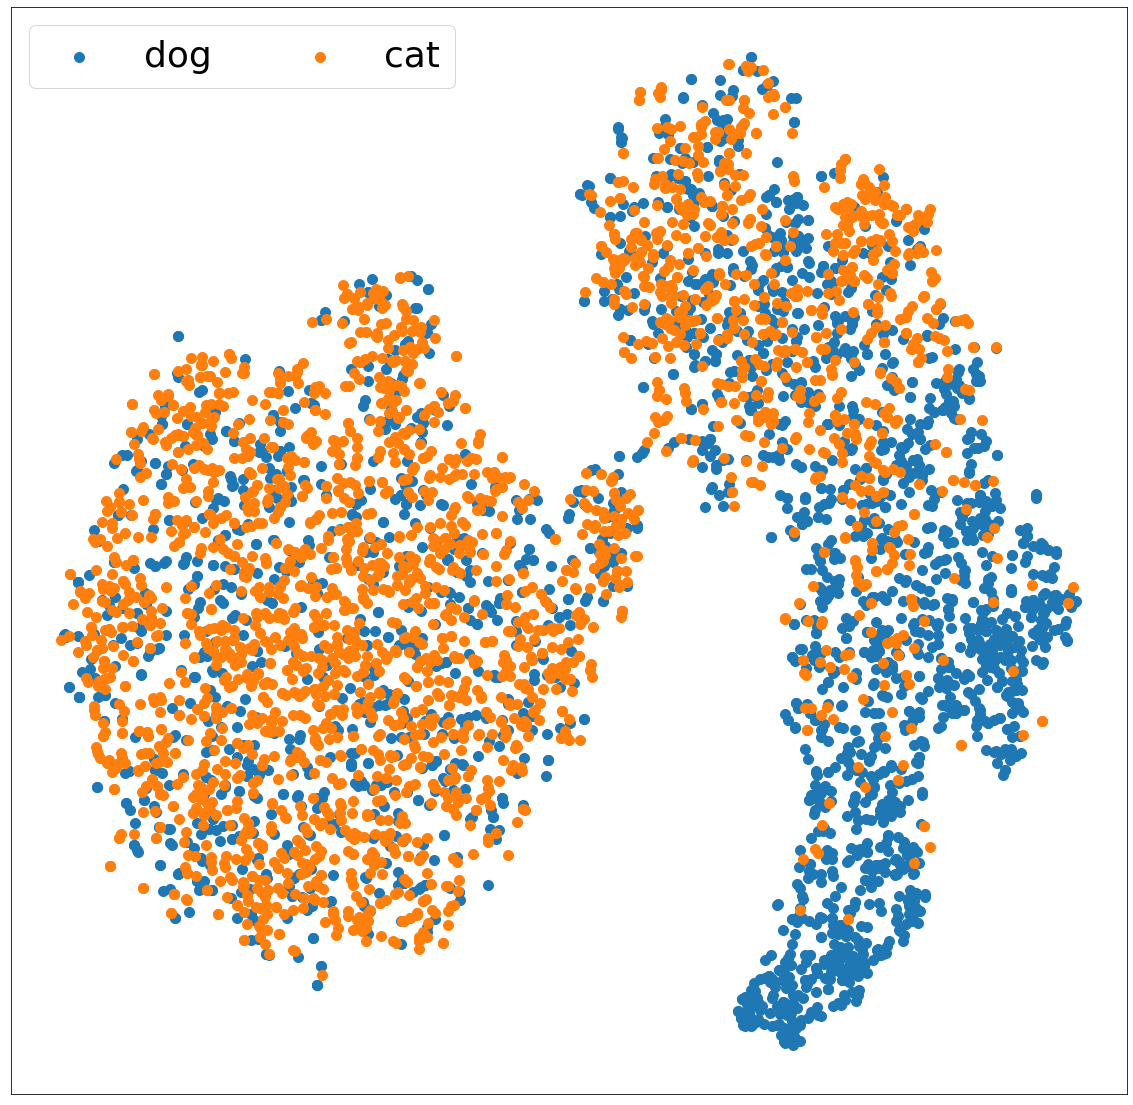

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

for i in range(2):
    sel_inds = np.argwhere(labels == i).flatten()
    ax.scatter(tsne_feats[:, 0][sel_inds], tsne_feats[:, 1][sel_inds], label=class_names[i], s=100)
    
ax.legend(fontsize=36, ncol=2, loc=2)
ax.set_xticks([])
ax.set_yticks([])